# Stroke Prediction Project

This project investigates the use of machine learning models to predict stroke risk based on demographic and clinical features from electronic health records. The goal is to assess how accurately models like Random Forest, Logistic Regression, Gradient Boosting, and Support Vector Machines can predict stroke and compare their performance. The findings could potentially lead to the development of real-time clinical tools that estimate a patient's stroke risk, guiding further tests, preventative actions, or specialist referrals to improve patient outcomes and reduce stroke incidence.

It is important to note that there is no information about where or how the data was collected; it is unclear whether the data represents real patient information, de-identified clinical records, or entirely synthetic cases. While this limits the ability to generalize findings to a specific population or clinical setting, the models developed still offer valuable insights into how key risk factors such as age, hypertension, and heart disease, can contribute to stroke risk. The results demonstrate the potential for predictive modeling in supporting clinical decision-making, even if further validation with real-world data would be necessary for deployment.

In [21]:
import pandas as pd
import numpy as np

# Load the dataset
stroke = pd.read_csv("stroke.csv")

# Preview the data
print(stroke.head())

# Check data types
print(stroke.info())

# Convert id to string, bmi to numeric (with coercion of errors)
stroke['id'] = stroke['id'].astype(str)
stroke['bmi'] = pd.to_numeric(stroke['bmi'], errors='coerce')

# Convert categorical variables to category dtype
categorical_vars = ["gender", "hypertension", "heart_disease", "ever_married",
                    "work_type", "Residence_type", "smoking_status", "stroke"]
for col in categorical_vars:
    stroke[col] = stroke[col].astype('category')

# Check for missing values
print("Total missing values:", stroke.isna().sum().sum())
print("Columns with missing values:", stroke.columns[stroke.isna().any()])

# Check data types
print(stroke.info())

# bmi column has 10 missing values

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 e

In [22]:
# Check for duplicated rows
print("Number of duplicate rows:", stroke.duplicated().sum())

# Frequency of each gender category
print("Gender distribution:")
print(stroke['gender'].value_counts(dropna=False))

# Remove rows with 'Other' in gender
stroke = stroke[stroke['gender'].isin(['Female', 'Male'])]
stroke['gender'] = stroke['gender'].cat.remove_unused_categories()

# Unique values per column
print("Unique values per column:")
print(stroke.nunique())

# Number of rows
print("Number of rows:", stroke.shape[0])

# Stroke class balance
print("Stroke distribution:")
print(stroke['stroke'].value_counts())

Number of duplicate rows: 0
Gender distribution:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Unique values per column:
id                   5109
gender                  2
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3978
bmi                   418
smoking_status          4
stroke                  2
dtype: int64
Number of rows: 5109
Stroke distribution:
stroke
0    4860
1     249
Name: count, dtype: int64


<ipython-input-23-4ad70a11bf46>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=stroke, x='stroke', palette='Blues')


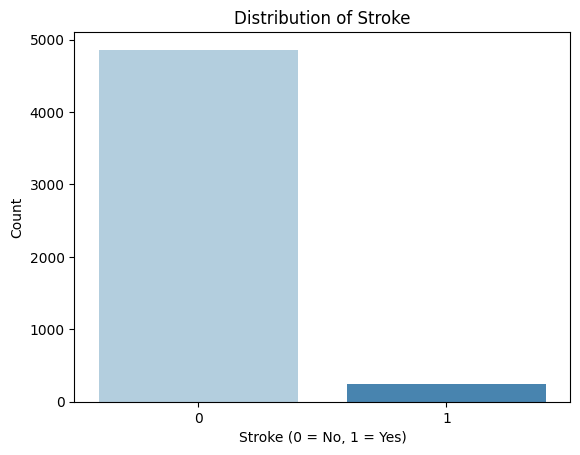

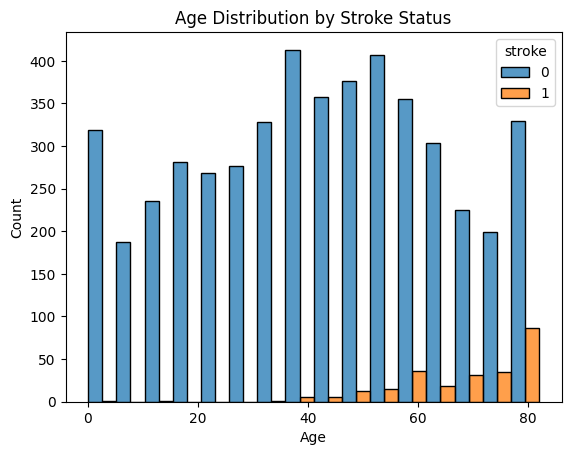

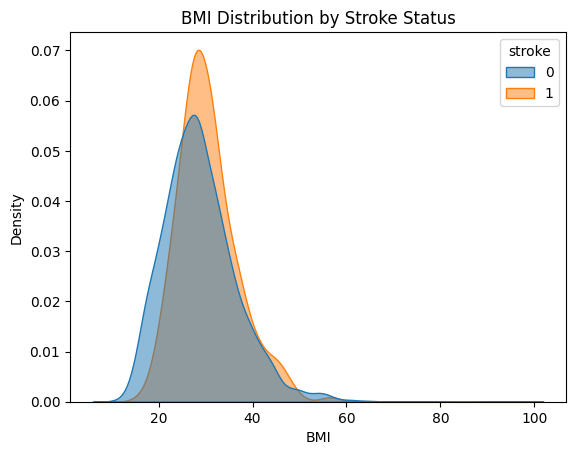

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Stroke distribution
sns.countplot(data=stroke, x='stroke', palette='Blues')
plt.title("Distribution of Stroke")
plt.xlabel("Stroke (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Age distribution by stroke status
sns.histplot(data=stroke, x='age', hue='stroke', bins=16, kde=False, multiple='dodge')
plt.title("Age Distribution by Stroke Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# BMI density plot by stroke status
sns.kdeplot(data=stroke, x='bmi', hue='stroke', fill=True, common_norm=False, alpha=0.5)
plt.title("BMI Distribution by Stroke Status")
plt.xlabel("BMI")
plt.show()

Target variable ("stroke") is heavily imbalanced. Given the class imbalance, particular attention is paid to the models' ability to correctly identify the positive class (true positives).

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Drop unnecessary columns and missing values
stroke_data = stroke.drop(columns=['id'])
stroke_data = stroke_data.dropna()

# encode categorical variables
stroke_data_encoded = pd.get_dummies(stroke_data, drop_first=True)

# Split features and target
X = stroke_data_encoded.drop(columns='stroke_1')  # Assuming 1 is "Yes"
y = stroke_data_encoded['stroke_1']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train random forest
rf_model = RandomForestClassifier(
    n_estimators=200, max_leaf_nodes=2**10, min_samples_leaf=5, random_state=42
)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]


Confusion Matrix:
[[940   0]
 [ 42   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       940
        True       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982


ROC AUC Score: 0.7655


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


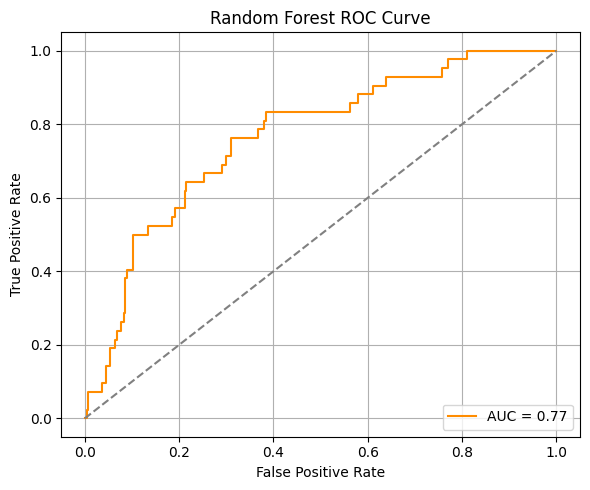

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-26-4877edc2725b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[:15], y=feature_importance.index[:15], palette="viridis")


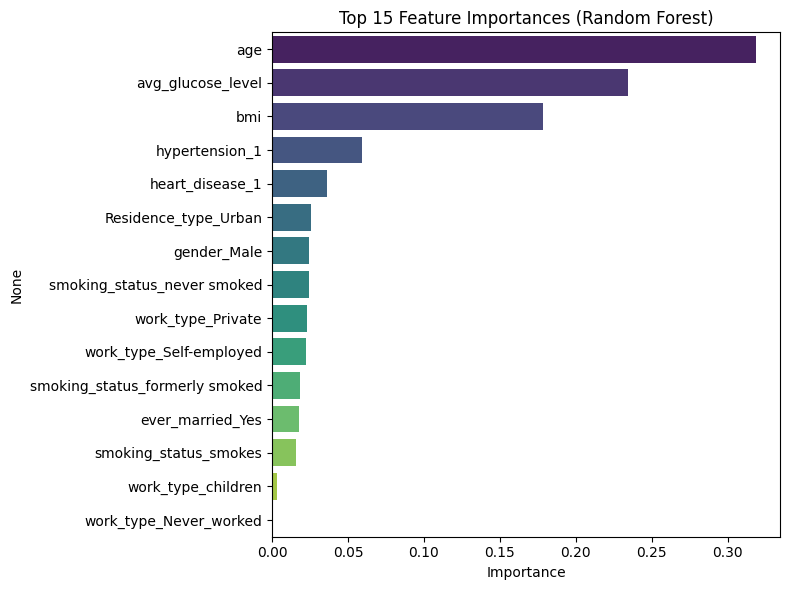

In [26]:
# Feature importance (from random forest)
import numpy as np
import pandas as pd

feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance[:15], y=feature_importance.index[:15], palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Logistic Regression - Confusion Matrix
[[940   0]
 [ 42   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       940
        True       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982

Logistic Regression - AUC: 0.8078


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


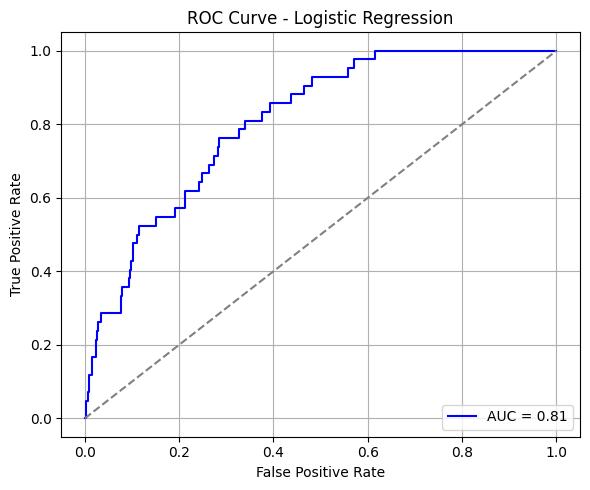

In [27]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Predict probabilities and classes
log_probs = log_model.predict_proba(X_test)[:, 1]
log_preds = (log_probs > 0.5).astype(int)

# Evaluation
print("Logistic Regression - Confusion Matrix")
print(confusion_matrix(y_test, log_preds))

print("\nClassification Report:")
print(classification_report(y_test, log_preds))

# AUC
log_auc = roc_auc_score(y_test, log_probs)
print(f"Logistic Regression - AUC: {log_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, log_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {log_auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


Gradient Boosting - Confusion Matrix
[[935   5]
 [ 41   1]]

Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.99      0.98       940
        True       0.17      0.02      0.04        42

    accuracy                           0.95       982
   macro avg       0.56      0.51      0.51       982
weighted avg       0.92      0.95      0.94       982

Gradient Boosting - AUC: 0.7953


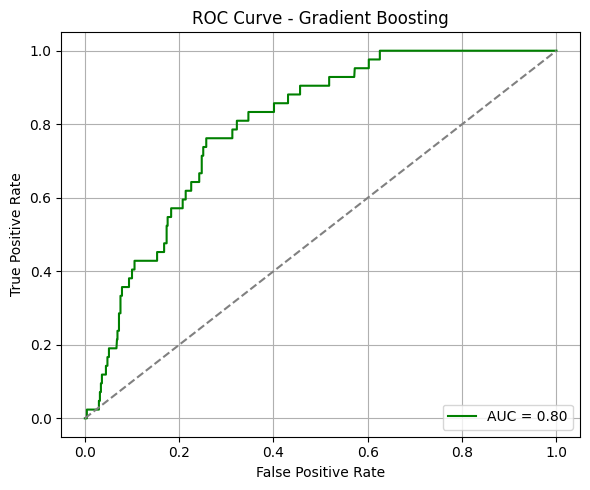

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_model.fit(X_train, y_train)

# Predict probabilities and classes
gbm_probs = gbm_model.predict_proba(X_test)[:, 1]
gbm_preds = (gbm_probs > 0.5).astype(int)

# Evaluation
print("Gradient Boosting - Confusion Matrix")
print(confusion_matrix(y_test, gbm_preds))

print("\nClassification Report:")
print(classification_report(y_test, gbm_preds))

# AUC
gbm_auc = roc_auc_score(y_test, gbm_probs)
print(f"Gradient Boosting - AUC: {gbm_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gbm_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {gbm_auc:.2f}", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


SVM - Confusion Matrix
[[940   0]
 [ 42   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       940
        True       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982

SVM - AUC: 0.6148


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


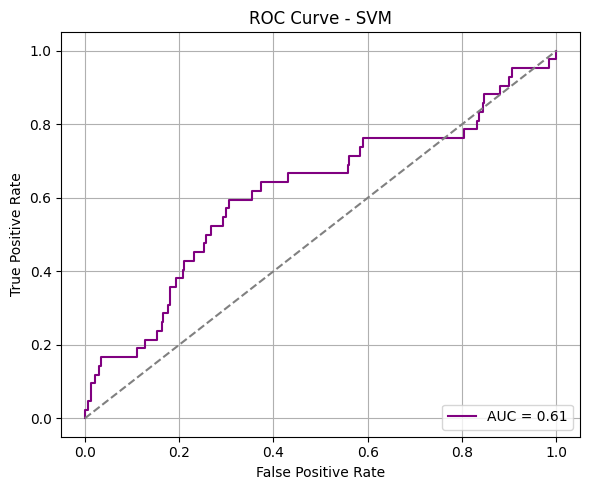

In [29]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# SVM with scaled features
svm_model = make_pipeline(StandardScaler(), SVC(probability=True, kernel='rbf', random_state=42))

# Train SVM model
svm_model.fit(X_train, y_train)

# Predict probabilities and classes
svm_probs = svm_model.predict_proba(X_test)[:, 1]
svm_preds = (svm_probs > 0.5).astype(int)

# Evaluation
print("SVM - Confusion Matrix")
print(confusion_matrix(y_test, svm_preds))

print("\nClassification Report:")
print(classification_report(y_test, svm_preds))

# AUC
svm_auc = roc_auc_score(y_test, svm_probs)
print(f"SVM - AUC: {svm_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, svm_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {svm_auc:.2f}", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


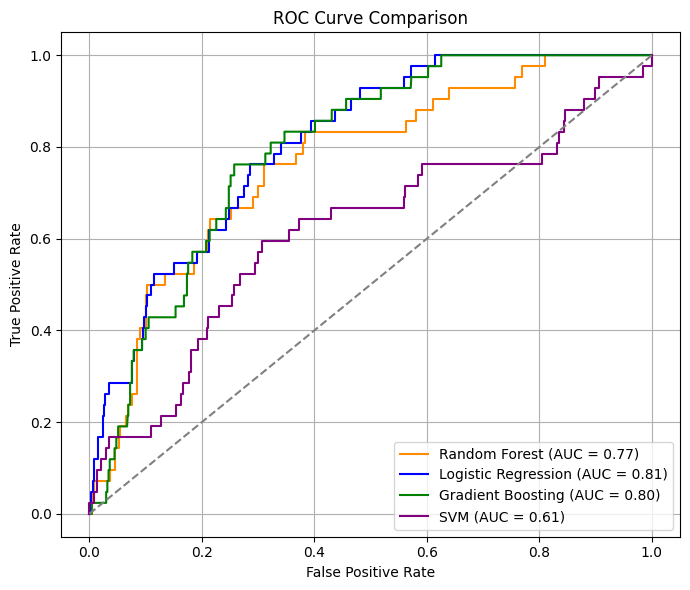

In [30]:
# Compare ROC curves for all models
plt.figure(figsize=(7, 6))

# Plot each model's ROC
plt.plot(*roc_curve(y_test, y_proba)[0:2], label=f"Random Forest (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot(*roc_curve(y_test, log_probs)[0:2], label=f"Logistic Regression (AUC = {log_auc:.2f})", color='blue')
plt.plot(*roc_curve(y_test, gbm_probs)[0:2], label=f"Gradient Boosting (AUC = {gbm_auc:.2f})", color='green')
plt.plot(*roc_curve(y_test, svm_probs)[0:2], label=f"SVM (AUC = {svm_auc:.2f})", color='purple')

# Diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
def calculate_sensitivity_specificity(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
  return sensitivity, specificity

print("\n Model Performance Metrics")

# Random Forest
rf_sensitivity, rf_specificity = calculate_sensitivity_specificity(y_test, y_pred)
print(f"\nRandom Forest:")
print(f"Sensitivity (Recall): {rf_sensitivity:.4f}")
print(f"Specificity: {rf_specificity:.4f}")

# Logistic Regression
log_sensitivity, log_specificity = calculate_sensitivity_specificity(y_test, log_preds)
print(f"\nLogistic Regression:")
print(f"Sensitivity (Recall): {log_sensitivity:.4f}")
print(f"Specificity: {log_specificity:.4f}")

# Gradient Boosting
gbm_sensitivity, gbm_specificity = calculate_sensitivity_specificity(y_test, gbm_preds)
print(f"\nGradient Boosting:")
print(f"Sensitivity (Recall): {gbm_sensitivity:.4f}")
print(f"Specificity: {gbm_specificity:.4f}")

# SVM
svm_sensitivity, svm_specificity = calculate_sensitivity_specificity(y_test, svm_preds)
print(f"\nSVM:")
print(f"Sensitivity (Recall): {svm_sensitivity:.4f}")
print(f"Specificity: {svm_specificity:.4f}")


 Model Performance Metrics

Random Forest:
Sensitivity (Recall): 0.0000
Specificity: 1.0000

Logistic Regression:
Sensitivity (Recall): 0.0000
Specificity: 1.0000

Gradient Boosting:
Sensitivity (Recall): 0.0238
Specificity: 0.9947

SVM:
Sensitivity (Recall): 0.0000
Specificity: 1.0000


# Results:

All models achieved high overall accuracy, ranging from 95% to 96%, largely due to the dominance of the majority class (non-stroke cases). However, high accuracy did not translate into effective detection of stroke cases (true positives). Sensitivity, which reflects the ability to correctly identify stroke cases, was notably low across all models except for GBM, which had a sensitivity of 2.4%. In contrast, all models showed very high specificity, exceeding 99%, indicating strong performance in identifying non-stroke cases. Precision (positive predictive value) varied across models. GBM achieved the highest precision for stroke cases (the positive class) at 17%, while Random Forest, Logistic Regression, and SVM all had a precision of 0.00%, meaning they failed to correctly identify any true stroke cases. The lack of positive predictions by these models highlights the challenge of detecting the minority class in imbalanced datasets.

In terms of overall discrimination, Logistic Regression achieved the highest ROC-AUC of 0.8078, followed by GBM (0.7953), Random Forest (0.7655), and SVM (0.6148), suggesting that GBM and Logistic Regression provided better separation between classes despite the class imbalance. McNemar’s test revealed significant discrepancies between observed and predicted classifications in all models (p < 0.001), indicating that the systematic misclassification was likely due to the imbalanced nature of the dataset.

# Discussion:

This study investigated using machine learning models (Random Forest, Logistic Regression, Gradient Boosting, and SVM) to predict stroke outcomes. While models showed high overall accuracy due to the majority of non-stroke cases, they performed poorly in identifying actual stroke events (low sensitivity). Logistic Regression and Gradient Boosting had the best discrimination (ROC-AUC of 0.8078 and 0.7953 respectively), while Random Forest identified key stroke predictors (glucose, age, BMI). Despite low sensitivity, the findings suggest potential for using these models in clinical decision support systems for early stroke risk prediction, potentially integrated into electronic health records for risk stratification and preventative care guidance. Real-world application would require further validation and monitoring.

Future work needs to address class imbalance to improve the detection of minority stroke cases without losing accuracy. Enhancing model sensitivity and maintaining interpretability are crucial for developing trustworthy stroke prediction tools. It's also important to acknowledge the lack of information about the data's origin (real vs. synthetic patients), limiting generalizability. Despite this, the models provided insights into how factors like age, hypertension, and heart disease influence stroke risk. These results highlight the promise of predictive modeling in assisting clinical decisions. However, real-world deployment requires further validation with authentic patient data.

# References:

Soriani, F. (2021). Stroke Prediction Dataset [Data set]. Kaggle. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset